In [1]:
import sys
import requests
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

sys.path.append("..")
import geoobb.obb as obb

## Load Data


4000 records returned


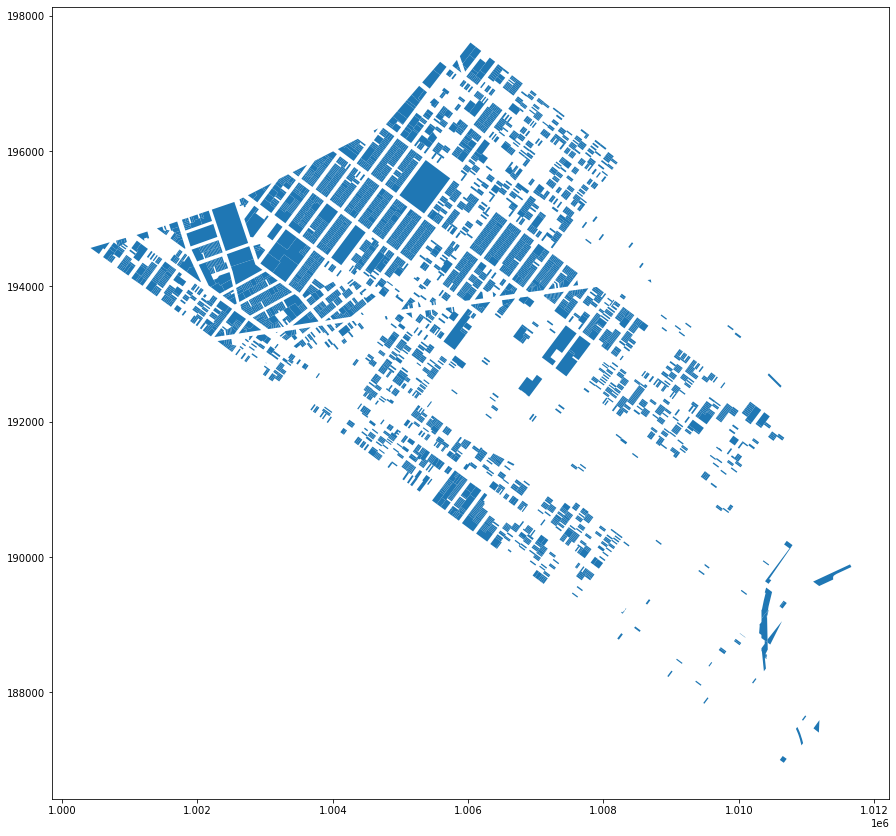

In [2]:
api_url = r'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query'

params = {
    'where': 'CD = 304',
    'f': 'pgeojson',
    'outFields': 'BBL, LotDepth, LotFront',
}

r = requests.get(api_url, params=params)

gdf = gpd.read_file(r.text)
gdf.to_crs(epsg=2263, inplace=True)

# the api has a max record limit of 4000
print(f'{len(gdf)} records returned')

gdf.plot(figsize=(15, 15));

In [3]:
gdf.head()

,BBL,LotDepth,LotFront,geometry
0,3031310039,100.0,18.87,"POLYGON ((1000926.462 194530.369, 1000915.226 ..."
1,3031320012,100.0,18.75,"POLYGON ((1000999.966 194359.309, 1000991.543 ..."
2,3031320027,125.0,225.00,"POLYGON ((1001267.342 194554.616, 1001131.464 ..."
3,3031320041,100.0,25.10,"POLYGON ((1001071.821 194287.833, 1001026.332 ..."
4,3031327503,100.0,25.00,"POLYGON ((1001076.242 194463.125, 1000992.666 ..."


## Generate OBBs


### Geometry exterior


In [3]:
%timeit gdf.geometry.map(obb.geom_to_unique_array)

10 loops, best of 3: 184 ms per loop


In [6]:
geo_arrs = gdf.geometry.map(obb.geom_to_unique_array)
%timeit geo_arrs.map(obb.oriented_bounding_box)

1 loop, best of 3: 376 ms per loop


### Convex Hull


In [6]:
%timeit gdf.geometry.convex_hull.map(obb.geom_to_array)

10 loops, best of 3: 122 ms per loop


In [7]:
convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
%timeit convex_hull_arrs.map(obb.oriented_bounding_box)

1 loop, best of 3: 373 ms per loop


Performance: pretty fast for 4,000 geometries! Looks like getting the necessary geoms from the convex hull is faster overall, but doesn't improve performance down the line.


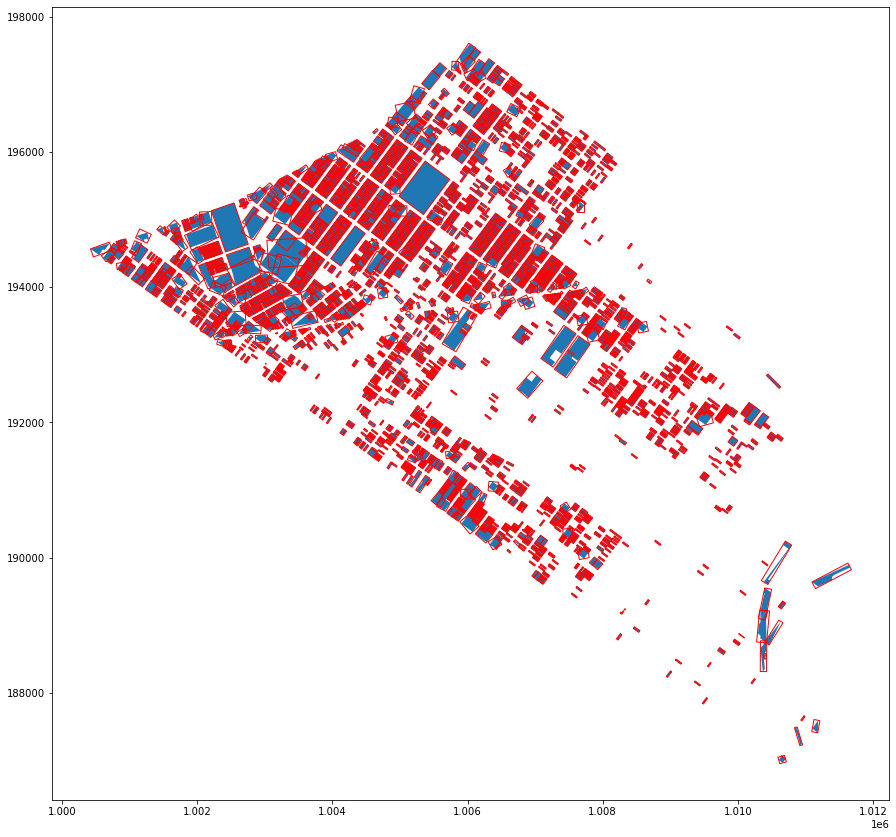

In [16]:
obbs = geo_arrs.apply(obb.oriented_bounding_box)

obbs_gs = gpd.GeoSeries(obbs.map(obb.polygon_from_obb), crs=gdf.crs)
ax = gdf.plot(figsize=(15, 15))
obbs_gs.plot(ax=ax, linewidth=1, edgecolor='red', facecolor='none')
plt.savefig('./images/obbs.jpg', dpi=72, bbox_inches='tight', pad_inches=0.1)
plt.show();

## Determine Parcel Orientions


In [10]:
angles = np.array([obb.obb_angle(o) for o in obbs])
abs_angles = np.abs(angles)

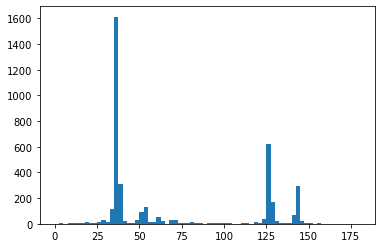

In [11]:
plt.hist(np.degrees(abs_angles), bins=np.arange(0, 182.5, 2.5));

In [12]:
np.median(abs_angles), np.mean(abs_angles)

(0.661001838516494, 1.2309783264133554)

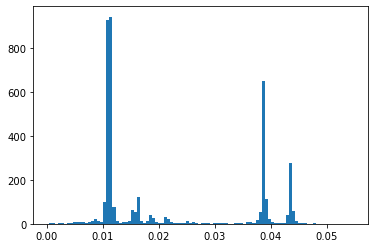

In [13]:
plt.hist(np.radians(abs_angles), bins=100);

## Median Parcel Orientation


In [14]:
med_angle = np.median(abs_angles)

med_angle

0.661001838516494

In [15]:
median_obb_idx = np.argmin(np.abs(angles - med_angle))

median_obb_idx

514

### Transform Geoms


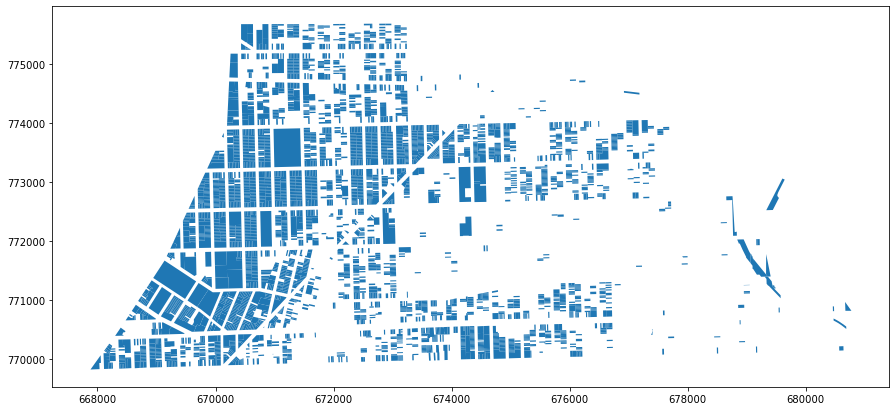

In [16]:
tvect = obb.pca_eigenvectors(geo_arrs[median_obb_idx])
af_mat = np.append(np.ravel(tvect.T), np.zeros(2))

rot_geos = gdf.copy()
rot_geos.geometry = gdf.geometry.affine_transform(af_mat)

rot_geos.plot(figsize=(15, 15));

## Test Spatial Join


### Without transformation


In [17]:
xmin, ymin, xmax, ymax = gdf.sindex.bounds
rand_pts = np.random.uniform(low=(xmin, ymin), high=(xmax, ymax), size=(100000, 2))

test_pts = gpd.GeoDataFrame(geometry=[Point(p) for p in rand_pts], crs=gdf.crs)

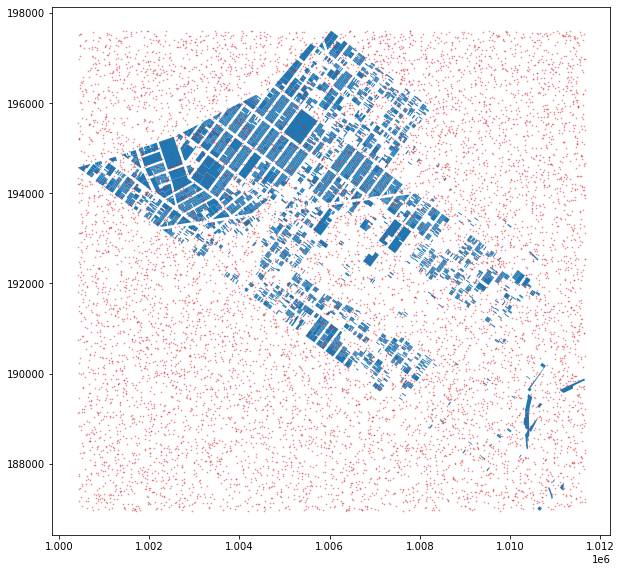

In [18]:
ax = gdf.plot(figsize=(10, 10))
test_pts.sample(10000).plot(ax=ax, alpha=0.5, marker='.', color='tab:red', markersize=1.5);

In [19]:
%timeit gpd.sjoin(test_pts, gdf, op='within')

The slowest run took 6.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 403 ms per loop


In [20]:
regular_join_result = gpd.sjoin(test_pts, gdf, op='within')

In [21]:
len(regular_join_result)

11256

### Rotated


In [22]:
% timeit test_pts.geometry.affine_transform(af_mat)

1 loop, best of 3: 1.25 s per loop


In [23]:
rot_test_pts = test_pts.geometry.affine_transform(af_mat)
rot_test_pts = gpd.GeoDataFrame(rot_test_pts, columns=['geometry'])

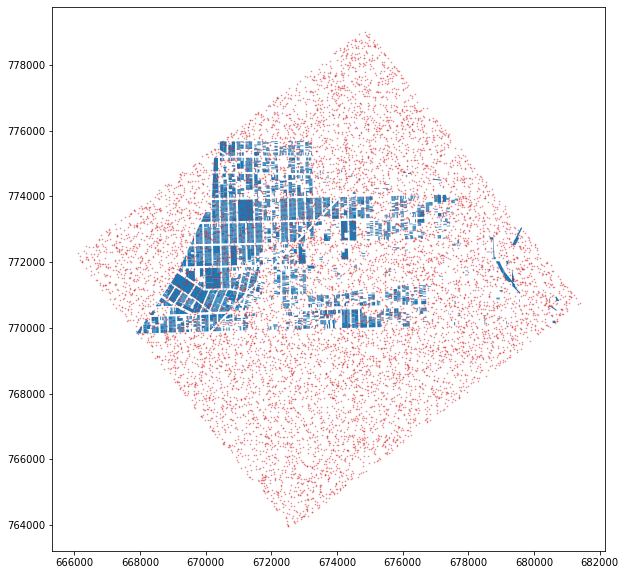

In [24]:
ax = rot_geos.plot(figsize=(10, 10))
rot_test_pts.sample(10000).plot(ax=ax, alpha=0.5, marker='.', color='tab:red', markersize=1.5);

In [25]:
%timeit gpd.sjoin(rot_test_pts, rot_geos, op='within')

The slowest run took 6.81 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 349 ms per loop


In [26]:
obb_join_result = gpd.sjoin(rot_test_pts, rot_geos, op='within')

In [27]:
len(obb_join_result)

11256

Sadly, impromevement is not worth the added steps in this case


## Parcel Dimensions


In [46]:
convex_hull_arrs = gdf.geometry.map(obb.geom_to_array)
obbs = convex_hull_arrs.apply(obb.oriented_bounding_box)
obbs_gs = gpd.GeoSeries(obbs.map(obb.polygon_from_obb), crs=gdf.crs)
dims = obbs.map(obb.obb_dimensions)

In [47]:
gdf

,BBL,LotDepth,LotFront,geometry,edge_len1,edge_len2
0,3031310039,100.0,18.87,"POLYGON ((1000926.462 194530.369, 1000915.226 ...",100.979528,19.076953
1,3031320012,100.0,18.75,"POLYGON ((1000999.966 194359.309, 1000991.543 ...",104.513276,19.425871
2,3031320027,125.0,225.00,"POLYGON ((1001267.342 194554.616, 1001131.464 ...",139.434810,243.766984
3,3031320041,100.0,25.10,"POLYGON ((1001071.821 194287.833, 1001026.332 ...",100.446155,24.529409
4,3031327503,100.0,25.00,"POLYGON ((1001076.242 194463.125, 1000992.666 ...",104.566357,25.051740
...,...,...,...,...,...,...
3995,3032197501,100.0,25.00,"POLYGON ((1005251.115 194502.876, 1005235.496 ...",103.190656,26.131326
3996,3032200001,100.0,25.00,"POLYGON ((1005601.813 195014.800, 1005623.526 ...",27.482295,103.859101
3997,3032200002,100.0,25.00,"POLYGON ((1005601.813 195014.800, 1005539.755 ...",27.195777,103.806313
3998,3032200004,100.0,25.00,"POLYGON ((1005560.503 195045.683, 1005498.445 ...",25.169963,103.803715


In [48]:
gdf['edge_len1'] = dims.map(lambda x: x[0])
gdf['edge_len2'] = dims.map(lambda x: x[1])

In [49]:
# sort each row by edge length
original_dims = gdf[['LotDepth', 'LotFront']].values
original_dims.sort(axis=1)

In [50]:
original_dims

array([[ 18.87, 100.  ],
       [ 18.75, 100.  ],
       [125.  , 225.  ],
       ...,
       [ 25.  , 100.  ],
       [ 25.  , 100.  ],
       [ 75.  , 100.  ]])

In [51]:
calc_dims = np.array([x for x in dims])
calc_dims.sort(axis=1)

In [52]:
calc_dims

array([[ 19.07695308, 100.97952767],
       [ 20.97208362, 104.78952599],
       [129.96456322, 232.59389526],
       ...,
       [ 27.19577708, 103.80631257],
       [ 25.16996312, 103.80371477],
       [148.92885544, 209.26722619]])

In [53]:
x, y = (original_dims - calc_dims).T

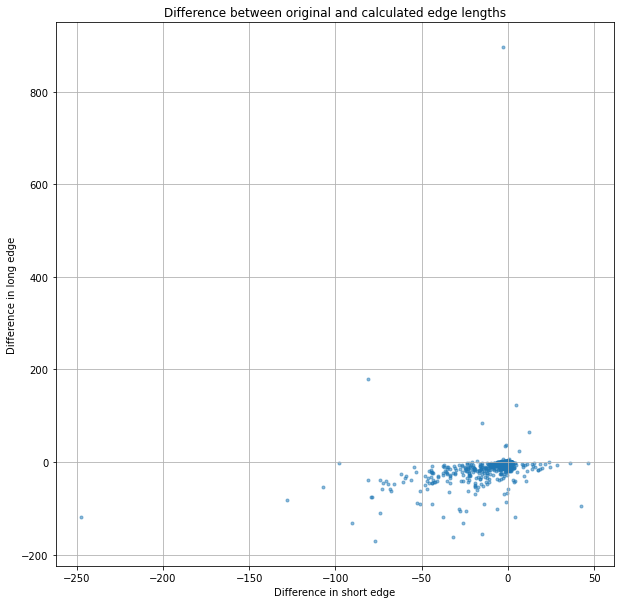

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*(original_dims - calc_dims).T, alpha=0.5, marker='.')
plt.title('Difference between original and calculated edge lengths')
plt.xlabel('Difference in short edge')
plt.ylabel('Difference in long edge')
plt.grid()
plt.show();

In [55]:
gdf

,BBL,LotDepth,LotFront,geometry,edge_len1,edge_len2
0,3031310039,100.0,18.87,"POLYGON ((1000926.462 194530.369, 1000915.226 ...",100.979528,19.076953
1,3031320012,100.0,18.75,"POLYGON ((1000999.966 194359.309, 1000991.543 ...",104.789526,20.972084
2,3031320027,125.0,225.00,"POLYGON ((1001267.342 194554.616, 1001131.464 ...",129.964563,232.593895
3,3031320041,100.0,25.10,"POLYGON ((1001071.821 194287.833, 1001026.332 ...",100.688909,25.543412
4,3031327503,100.0,25.00,"POLYGON ((1001076.242 194463.125, 1000992.666 ...",104.566357,25.051740
...,...,...,...,...,...,...
3995,3032197501,100.0,25.00,"POLYGON ((1005251.115 194502.876, 1005235.496 ...",103.190656,26.131326
3996,3032200001,100.0,25.00,"POLYGON ((1005601.813 195014.800, 1005623.526 ...",27.482295,103.859101
3997,3032200002,100.0,25.00,"POLYGON ((1005601.813 195014.800, 1005539.755 ...",27.195777,103.806313
3998,3032200004,100.0,25.00,"POLYGON ((1005560.503 195045.683, 1005498.445 ...",25.169963,103.803715


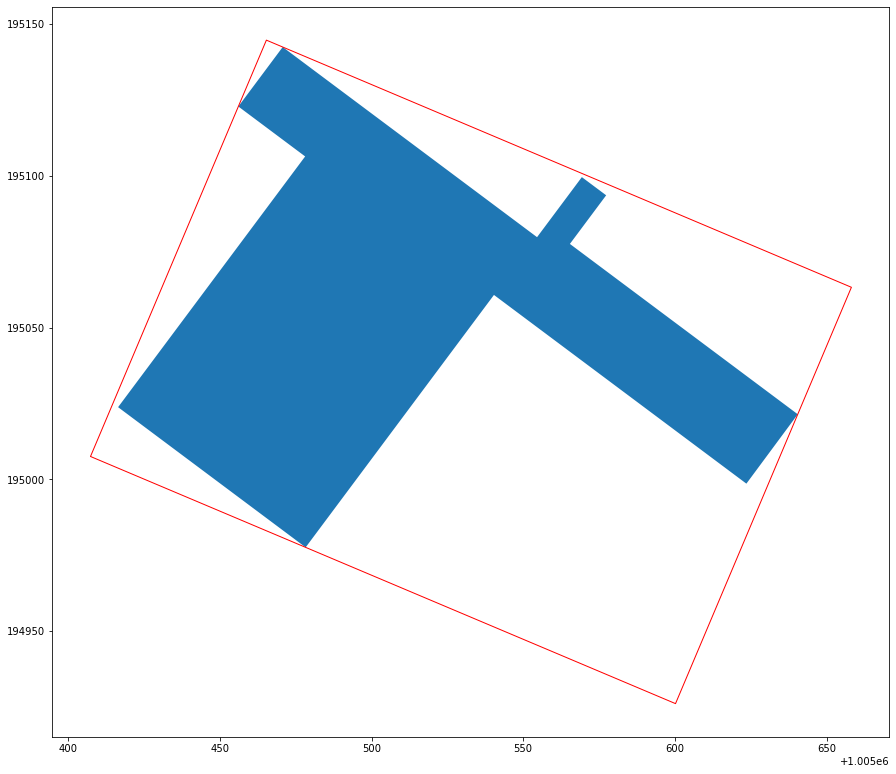

In [56]:
examples = [3999]

ax = gdf.iloc[examples].plot(figsize=(15, 15))
obbs_gs.iloc[examples].plot(ax=ax, linewidth=1, edgecolor='red', facecolor='none')

plt.show();

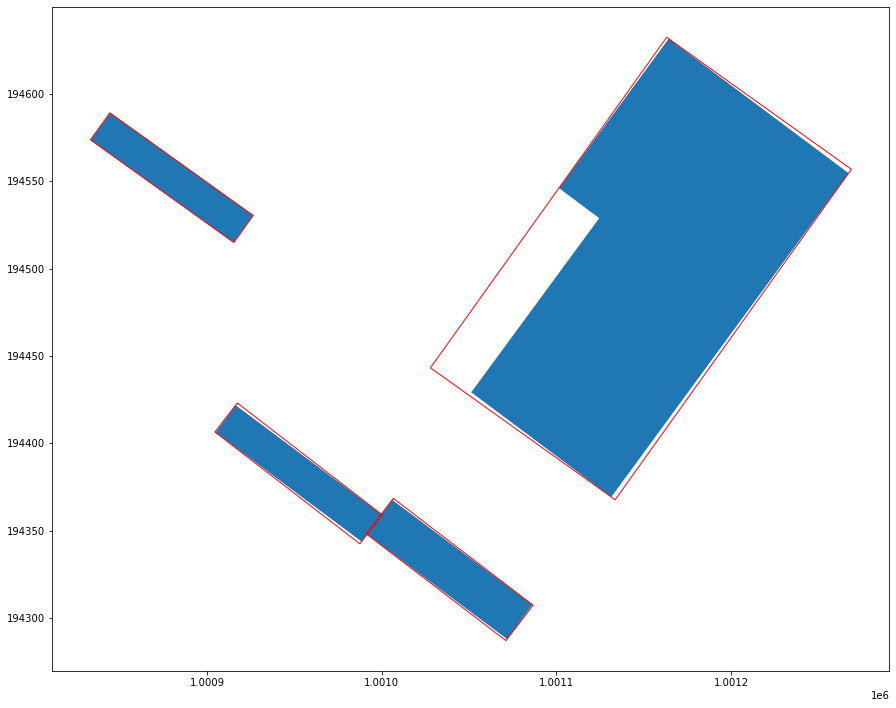

In [57]:
examples = np.arange(4)

ax = gdf.iloc[examples].plot(figsize=(15, 15))
obbs_gs.iloc[examples].plot(ax=ax, linewidth=1, edgecolor='red', facecolor='none')

plt.show();

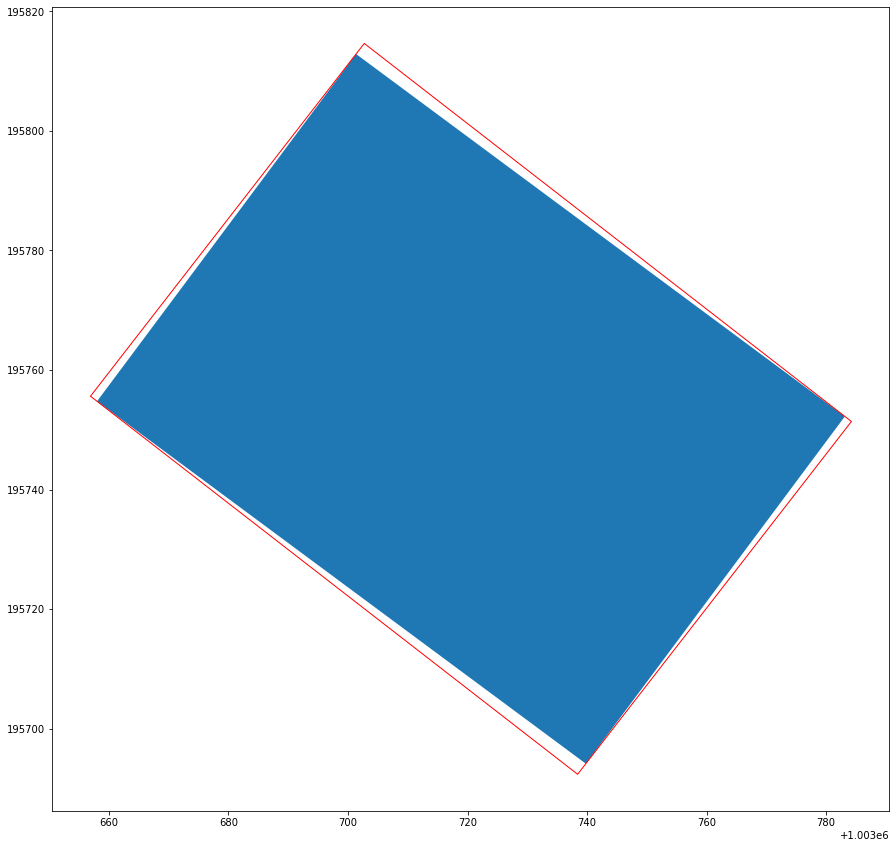

In [58]:
examples = ['3031557501']

f = gdf.BBL.isin(examples)
ax = gdf[f].plot(figsize=(15, 15))
obbs_gs[f].plot(ax=ax, linewidth=1, edgecolor='red', facecolor='none')

plt.show();

In [67]:
gdf.to_file('../data/obbs_dims.shp')